In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, preprocessing, svm
from sklearn.preprocessing import StandardScaler, Normalizer
import math
import matplotlib
import seaborn as sns
%matplotlib inline

In [2]:
def category_values(dataframe, categories):
    for c in categories:
        print('\n', dataframe.groupby(by=c)[c].count().sort_values(ascending=False))
        print('Nulls: ', dataframe[c].isnull().sum())

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

In [3]:
df = pd.read_csv('autos.csv', sep=',', header=0, encoding='cp1252')
#df = pd.read_csv('autos.csv.gz', sep=',', header=0, compression='gzip',encoding='cp1252')
df.sample(1)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
204058,2016-03-14 12:36:20,Verkaufe_Golf_6_tsi_highline_160ps,privat,Angebot,7000,test,NaN,2018,manuell,160,golf,150000,10,NaN,volkswagen,nein,2016-03-14 00:00:00,0,39122,2016-03-21 02:16:04


In [4]:
df.drop(['seller', 'offerType', 'abtest', 'dateCrawled', 'nrOfPictures', 'lastSeen', 'postalCode', 'dateCreated', 'name'], axis='columns', inplace=True)


In [5]:
dedups = df.drop_duplicates(['price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])

In [6]:
dedups.isnull().sum()

price                      0
vehicleType            35088
yearOfRegistration         0
gearbox                17451
powerPS                    0
model                  18791
kilometer                  0
monthOfRegistration        0
fuelType               31109
brand                      0
notRepairedDamage      66775
dtype: int64

In [7]:
dedups = dedups[
        (dedups.yearOfRegistration <= 2016) 
      & (dedups.yearOfRegistration >= 1950) 
      & (dedups.price >= 100) 
      & (dedups.price <= 150000) 
      & (dedups.powerPS >= 10) 
      & (dedups.powerPS <= 500)]

In [8]:
dedups['notRepairedDamage'].fillna(value='not-declared', inplace=True)
dedups['fuelType'].fillna(value='not-declared', inplace=True)
dedups['gearbox'].fillna(value='not-declared', inplace=True)
dedups['vehicleType'].fillna(value='not-declared', inplace=True)
dedups['model'].fillna(value='not-declared', inplace=True)

In [9]:
dedups.isnull().sum()

price                  0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

In [10]:
labels = ['gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType']
les = {}

for l in labels:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(dedups[l])
    tr = les[l].transform(dedups[l]) 
    dedups.loc[:, l + '_feat'] = pd.Series(tr, index=dedups.index)

labeled = dedups[ ['price'
                        ,'yearOfRegistration'
                        ,'powerPS'
                        ,'kilometer'
                        ,'monthOfRegistration'
                        ] 
                    + [x+"_feat" for x in labels]]

In [11]:
# Linear Regression  Use One Hot Encoder   40 brand only

In [12]:
X_train = labeled.values
list1 = [len(dedups['gearbox_feat'].unique()),
len(dedups['notRepairedDamage_feat'].unique()),
len(dedups['model_feat'].unique()),
len(dedups['brand_feat'].unique()),
len(dedups['fuelType_feat'].unique()),
len(dedups['vehicleType_feat'].unique())]
# Use numbers to represent brand and type 
X_tn = []
for i in range(len(X_train)):
    list1=[1]
    for j in range(1,11):
        list1.append(X_train[i][j])
    X_tn.append(list1)

# Use One Hot Encoder   40 brand only
X_t = []
for i in range(len(X_train)):
    list1=[1]
    for j in range(1,5):
        list1.append(X_train[i][j])
    list2=[0]*3
    list2[X_train[i][5]]=1
    list1.extend(list2)
    list3=[0]*3
    list3[X_train[i][6]]=1
    list1.extend(list3)
    list4=[0]*40
    list4[X_train[i][8]]=1
    list1.extend(list4)
    list5=[0]*8
    list5[X_train[i][9]]=1
    list1.extend(list5)
    list6=[0]*9
    list6[X_train[i][10]]=1
    list1.extend(list6)
    X_t.append(list1)

In [13]:
Y_t = []
for i in range(len(X_train)):
    Y_t.append(X_train[i][0])

In [14]:
Xtrain = X_t[:(int)(len(X_t)/2)]
Xtest = X_t[(int)(len(X_t)/2):]
Ytrain = Y_t[:(int)(len(Y_t)/2)]
Ytest = Y_t[(int)(len(Y_t)/2):]

Xntrain = X_tn[:(int)(len(X_tn)/2)] # Only use numbers
Xntest = X_tn[(int)(len(X_tn)/2):]

In [15]:
model=linear_model.Ridge()
model.fit(Xtrain,Ytrain)
y_predict=model.predict(Xtrain)
for i in range(len(y_predict)):
    if y_predict[i] < 0:
        y_predict[i] = 0

error=0
for i in range(len(Ytrain)):
    error+=(Ytrain[i]-y_predict[i]) **2
train_error_ridge=error/len(Ytrain)
print("Train error = "'{}'.format(train_error_ridge)+"in Ridge Regression") #brand only

Train error = 22911234.499470744in Ridge Regression


In [16]:
# Linear Regression    Use model and brand

In [17]:
arr = dedups.values
l=[]
for i in range(len(arr)):
    l.append(arr[i][9]+'_'+arr[i][5])
ll = []
num = 0
for i in l:
    if i not in ll:
        ll.append(i)
        num += 1
#different value : 337
X_t = []
for i in range(len(X_train)):
    list1=[1]
    for j in range(1,5):
        list1.append(X_train[i][j])
    list2=[0]*3
    list2[X_train[i][5]]=1
    list1.extend(list2)
    list3=[0]*3
    list3[X_train[i][6]]=1
    list1.extend(list3)
    list4=[0]*337
    list4[ll.index(arr[i][9]+'_'+arr[i][5])]=1
    list1.extend(list4)
    list5=[0]*8
    list5[X_train[i][9]]=1
    list1.extend(list5)
    list6=[0]*9
    list6[X_train[i][10]]=1
    list1.extend(list6)
    X_t.append(list1)

In [18]:
Xtrain = X_t[:(int)(len(X_t)/2)]
Xtest = X_t[(int)(len(X_t)/2):]

In [ ]:
model=linear_model.Ridge()
model.fit(Xtrain,Ytrain)
y_predict=model.predict(Xtrain)
for i in range(len(y_predict)):
    if y_predict[i] < 0:
        y_predict[i] = 0

error=0
for i in range(len(Ytrain)):
    error+=(Ytrain[i]-y_predict[i]) **2
train_error_ridge=(error/len(Ytrain))
print("Train error = "'{}'.format(train_error_ridge)+"in Ridge Regression")  #Use model and brand


Train error = 19576077.922257043in Ridge Regression


In [ ]:
# two degree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(Xtrain)
regr.fit(X_, Ytrain)


result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Ytrain))

In [20]:
# Linear Regression  Use numpy

In [21]:
import numpy
theta,residuals,rank,s = numpy.linalg.lstsq(Xtrain, Ytrain)
y_predict = (numpy.matrix(theta) * numpy.matrix(Xtrain).T).tolist()[0]

for i in range(len(y_predict)):
    if y_predict[i] < 0:
        y_predict[i] = 0

error=0
for i in range(len(Ytrain)):
    error+=(Ytrain[i]-y_predict[i]) **2
train_error_ridge=(error/len(Ytrain))
print("Train error = "'{}'.format(train_error_ridge)+"in Ridge Regression")  #Use numpy

Train error = 19573228.052974954in Ridge Regression


In [ ]:
# Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

param_grid = { "criterion" : ["mse"]
              , "min_samples_leaf" : [3]
              , "min_samples_split" : [3]
              , "max_depth": [10]
              , "n_estimators": [500]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
gs = gs.fit(Xtrain, Ytrain)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [210]:
print(gs.best_score_)
print(gs.best_params_)

0.818093620625
{'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 500}


In [229]:
y_predict = gs.predict(Xtrain)
for i in range(len(y_predict)):
    if y_predict[i] < 0:
        y_predict[i] = 0

error=0
for i in range(len(Ytrain)):
    error+=(Ytrain[i]-y_predict[i]) **2
train_error_ridge=(error/len(Ytrain))
print("Train error = "'{}'.format(train_error_ridge)+"in Ridge Regression")  #Use Random Forest Regressor

In [ ]:
# Decision Tree

In [ ]:
import os
import pandas as pd
from pandas import DataFrame,Series
from sklearn import tree
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import neighbors
from sklearn import linear_model
%matplotlib inline
dec = tree.DecisionTreeRegressor(max_depth=5)
dec.fit(Xtrain,Ytrain)
y1_dec=dec.predict(Xtrain)
y2_dec=dec.predict(Xtest)


In [284]:
for i in range(len(y1_dec)):
    if y1_dec[i] < 0:
        y1_dec[i] = 0

error=0
for i in range(len(Ytrain)):
    error+=(Ytrain[i]-y1_dec[i]) **2
train_error_ridge=(error/len(Ytrain))
print("Train error = "'{}'.format(train_error_ridge)+"in Ridge Regression")

Train error = 2100806.855459263in Ridge Regression


In [285]:
for i in range(len(y2_dec)):
    if y2_dec[i] < 0:
        y2_dec[i] = 0

error=0
for i in range(len(Ytrain)):
    error+=(Ytrain[i]-y2_dec[i]) **2
train_error_ridge=(error/len(Ytrain))
print("Train error = "'{}'.format(train_error_ridge)+"in Ridge Regression")

Train error = 128776383.41185793in Ridge Regression


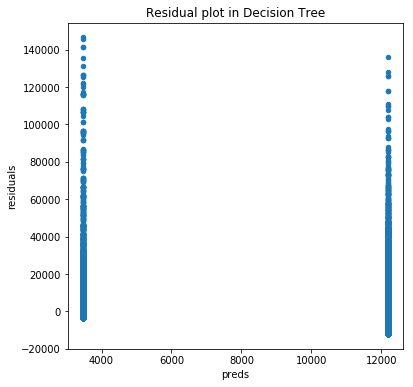

In [260]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":dec.predict(Xtrain), "true":Ytrain})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Decision Tree")

In [ ]:
# SVM

In [ ]:
svm_reg=svm.SVR()
svm_reg.fit(Xtrain,Ytrain)
y1_svm=svm_reg.predict(Xtrain)
y1_svm=list(y1_svm)
y2_svm=svm_reg.predict(Xtest)
y2_svm=list(y2_svm)
for i in range(len(y1_svm)):
    if y1_svm[i] < 0:
        y1_svm[i] = 0

error=0
for i in range(len(Ytrain)):
    error+=(Ytrain[i]-y1_svm[i]) **2
train_error_ridge=(error/len(Ytrain))
print("Train error = "'{}'.format(train_error_ridge)+"in Ridge Regression")

for i in range(len(y2_svm)):
    if y2_svm[i] < 0:
        y2_svm[i] = 0

error=0
for i in range(len(Ytrain)):
    error+=(Ytrain[i]-y2_svm[i]) **2
train_error_ridge=(error/len(Ytrain))
print("Train error = "'{}'.format(train_error_ridge)+"in Ridge Regression")

In [ ]:
MSE=0
for i in range(len(Ytrain)):
    MSE+=(Ytrain[i]-y1_svm[i]) **2
MSE=(MSE/len(Ytrain))
print("MSE = "'{}'.format(train_error_ridge)+"in SVM")

In [ ]:
# KNN

In [ ]:
import sklearn.metrics
from sklearn import neighbors
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(Xtrain,Ytrain)
y1_knn=knn.predict(Xtrain)
y1_knn=list(y1_knn)

In [ ]:
error=0
for i in range(len(Ytrain)):
    error+=(abs(Ytrain[i]-y1_knn[i]))**2
train_error_ridge=error/len(Ytrain)
print("Train error = "'{}'.format(train_error_ridge)+" percent in Ridge Regression")
r_squared = sklearn.metrics.r2_score(Ytrain, y1_knn)
r_squared

In [ ]:
y1_knn=knn.predict(Xtest)
y1_knn=list(y1_knn)
error=0
for i in range(len(Ytest)):
    error+=(abs(Ytest[i]-y1_knn[i]))**2
train_error_ridge=error/len(Ytest)
print("Train error = "'{}'.format(train_error_ridge)+" percent in Ridge Regression")
r_squared = sklearn.metrics.r2_score(Ytest, y1_knn)
r_squared

In [ ]:
# Encode Parameter     (power, kilometer, year)

In [24]:
temp = dedups

In [28]:
tarray = temp.values

In [35]:
for i in range(len(tarray)):
    tarray[i][2] = 2017 - tarray[i][2]

In [59]:
tarray[0]

array([18300, 'coupe', 6, 'manuell', 190, 'not-declared', 125000, 5,
       'diesel', 'audi', 'ja', 1, 0, 163, 1, 3, 3], dtype=object)

In [122]:
labels = ['gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType']
les = {}

for l in labels:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(dedups[l])
    tr = les[l].transform(dedups[l]) 
    dedups.loc[:, l + '_feat'] = pd.Series(tr, index=dedups.index)

labeled = dedups[ ['price'
                        ,'yearOfRegistration'
                        ,'powerPS'
                        ,'kilometer'
                        ,'monthOfRegistration'
                        ] 
                    + [x+"_feat" for x in labels]]

In [123]:
lable = labeled.values

In [126]:
lable[0]

array([18300,     6,   190,    25,     5,     1,     0,   163,     1,
           3,     3])

In [125]:
for i in range(len(lable)):
    lable[i][1] = 2017 - lable[i][1]
    lable[i][3] = (lable[i][3]*1.0)/5000

In [128]:
l=[]
for i in range(len(tarray)):
    l.append(tarray[i][9]+'_'+tarray[i][5])
ll = []
num = 0
for i in l:
    if i not in ll:
        ll.append(i)
        num += 1
#different value : 337
X_t = []
for i in range(len(lable)):
    list1=[1]
    for j in range(1,5):
        if j == 2:
            list1.append(lable[i][j] * 1.0/500)
        else:
            list1.append(lable[i][j])
        
    list2=[0]*3
    list2[lable[i][5]]=1
    list1.extend(list2)
    list3=[0]*3
    list3[lable[i][6]]=1
    list1.extend(list3)
    list4=[0]*337
    list4[ll.index(tarray[i][9]+'_'+tarray[i][5])]=1
    list1.extend(list4)
    list5=[0]*8
    list5[lable[i][9]]=1
    list1.extend(list5)
    list6=[0]*9
    list6[lable[i][10]]=1
    list1.extend(list6)
    X_t.append(list1)

In [129]:
Xtrain = X_t[:(int)(len(X_t)/2)]
Xtest = X_t[(int)(len(X_t)/2):]

In [132]:
model=linear_model.Ridge()
model.fit(Xtrain,Ytrain)
y_predict=model.predict(Xtrain)
for i in range(len(y_predict)):
    if y_predict[i] < 0:
        y_predict[i] = 0

error=0
for i in range(len(Ytrain)):
    error+=(Ytrain[i]-y_predict[i]) **2
train_error_ridge=(error/len(Ytrain))
print("Train error = "'{}'.format(train_error_ridge)+"in Ridge Regression")  #Use model and brand

Train error = 19576296.883333508in Ridge Regression


In [134]:
y_predict=model.predict(Xtest)
for i in range(len(y_predict)):
    if y_predict[i] < 0:
        y_predict[i] = 0
error=0
for i in range(len(Ytest)):
    error+=abs(Ytest[i]-y_predict[i])
train_error_ridge=(error/len(Ytest))
print("Train error = "'{}'.format(train_error_ridge)+"in Ridge Regression")  #Use model and brand

Train error = 2430.200117111016in Ridge Regression


In [ ]:
# Bayes  model

In [ ]:
reg = linear_model.BayesianRidge()
reg.fit(Xtrain,Ytrain)
train_pre=reg.predict(Xtrain)
train_pre=list(train_pre)
test_pre=reg.predict(Xtest)
test_pre=list(test_pre)




for i in range(len(train_pre)):
    if train_pre[i] < 0:
        train_pre[i] = 0

error=0
for i in range(len(Ytrain)):
    error+=abs(Ytrain[i]-train_pre[i])
train_error=(error/len(Ytrain))
print("Train error = "'{}'.format(train_error)+"in Bayesian")




for i in range(len(test_pre)):
    if test_pre[i] < 0:
        test_pre[i] = 0

error=0
for i in range(len(Ytest)):
    error+=abs(Ytest[i]-test_pre[i])
test_error=(error/len(Ytest))
print("Test error = "'{}'.format(test_error)+"in Bayesian")




In [ ]:
19576077.922257043